In [1]:
import numpy as np

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import compute_sigmalm0_SimIMREOBGenerateQNMFreqV2 as calcqnm
import h5py

import seaborn as sns
sns.set(style='ticks', context='notebook', palette='colorblind', font='serif')

import utils
plt.rcParams.update(utils.rcParams)
from jinja2 import Template
import lal

from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde as Bounded_1d_kde

In [2]:
# A list of events
event_list = ["GW150914", "GW170104", "GW170729", "S190519bj", \
              "S190521r", "S190630ag", "S190828j", "S190910s"]

# Color for each event
color_dict = {
    "S190519bj": sns.color_palette("Set1", desat=0.7)[0],
    "S190521r": sns.color_palette("Set1", desat=0.7)[0],
    "S190630ag": sns.color_palette("Set1", desat=0.7)[0],
    "S190828j": sns.color_palette("Set1", desat=0.7)[0],    
    "S190910s": sns.color_palette("Set1", desat=0.7)[0],
    "GW150914": sns.color_palette("Set1", desat=0.7)[0],
    "GW170104": sns.color_palette("Set1", desat=0.7)[0],
    "GW170729": sns.color_palette("Set1", desat=0.7)[0]
}
alpha = 0.2

# Prior used for each event
prior_dict = {
    "dtau_220-min": {"S190519bj": -0.8, "S190521r": -0.8, "S190630ag": -0.8, "S190828j": -0.8, "S190910s": -0.8, "GW150914": -0.8, "GW170104": -0.8, "GW170729": -0.8 },
    "dtau_220-max": {"S190519bj": 1.5, "S190521r": 1.5, "S190630ag": 1.5, "S190828j": 1.5, "S190910s": 3.0, "GW150914": 1.0, "GW170104": 1.5, "GW170729": 1.5},
    "domega_220-min": {"S190519bj": -0.8, "S190521r": -0.8, "S190630ag": -0.8, "S190828j": -0.8, "S190910s": -0.8, "GW150914": -0.8, "GW170104": -0.8, "GW170729": -0.8},
    "domega_220-max": {"S190519bj": 2.0, "S190521r": 1.0, "S190630ag": 1.0, "S190828j": 1.0, "S190910s": 1.0, "GW150914": 1.0, "GW170104": 1.0, "GW170729": 1.0}
}

data_file_path_template = "{event}/rin_{event}_pseobnrv4hm_{param}.dat.gz"

# Parameters to be visualized
params = ["domega_220", "dtau_220"]

/Users/abhirupghosh/Documents/Work/spinqnm/data/rin/utils.py:831: UserWarning: linewidths is ignored by contourf
  ax.contourf(XS, YS, ZS, levels=l, **kwargs)


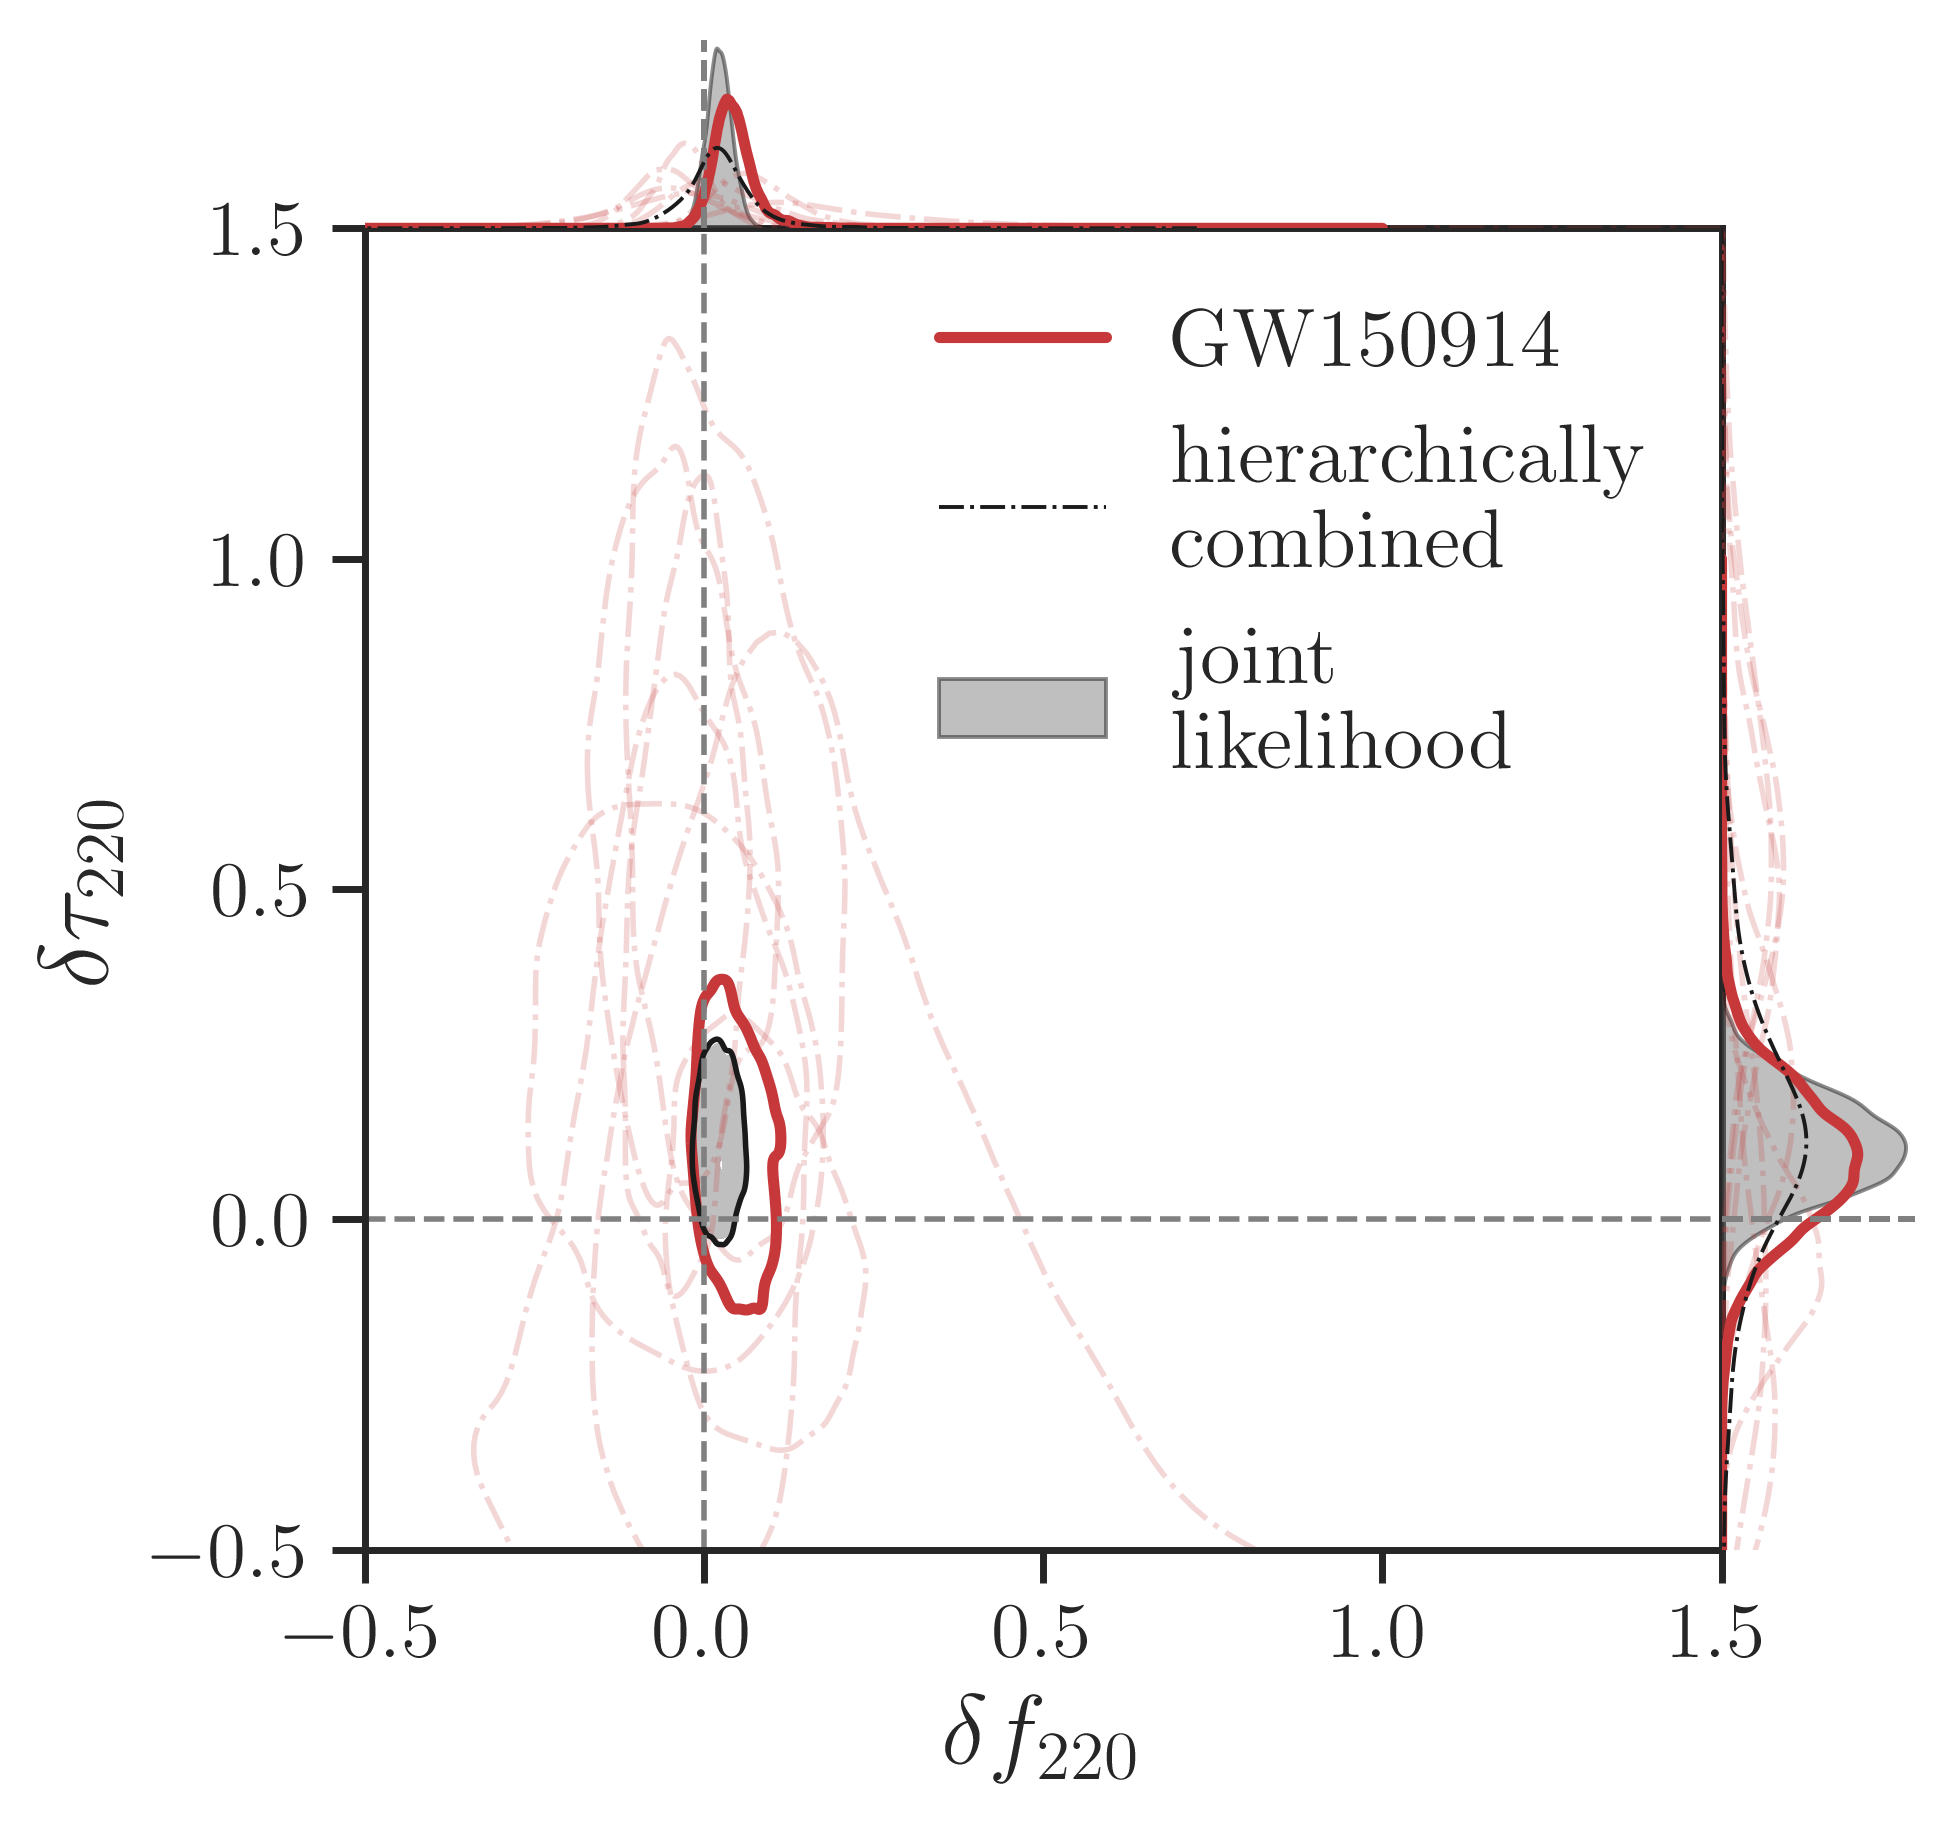

In [3]:
def kde_helper(samples, xlow=None, xhigh=None):
    # Initialize bounded KDE
    if xlow is None:
        xlow = np.amin(samples)
    if xhigh is None:
        xhigh = np.amax(samples)
    kde = Bounded_1d_kde(samples, xlow=xlow, xhigh=xhigh)
    pts = np.linspace(xlow, xhigh, num=500)
    pdf = kde(pts)
    
    return pts, pdf

# Load samples first
sample_dict = {}
for param in params:
    sample_dict[param] = {}
    for event in event_list:
        sample_dict[param][event] = np.loadtxt(data_file_path_template.format(event=event, param=param))

# Tune the min and max params
df_220_min = -0.5
df_220_max = 1.5
dtau_220_min = -0.5
dtau_220_max = 1.5
tick_pos = np.linspace(df_220_min, df_220_max, num=5)

#fig = plt.figure(dpi=150, figsize=utils.figsize_square) # Make a square plot
fig = plt.figure(figsize=(5,5), dpi=200)
gs = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[7,1], height_ratios=[1,7])
# Tune the plot settings
ax_joint = fig.add_subplot(gs[1,0])
ax_joint.set_xlabel(r"$\delta f_{220}$")
ax_joint.set_ylabel(r"$\delta \tau_{220}$")
ax_joint.set_xticks(tick_pos)
ax_joint.set_yticks(tick_pos)
linewidth = 1

ax_df_220 = fig.add_subplot(gs[0,0], sharex=ax_joint)
plt.setp(ax_df_220.get_xticklabels(), visible=False)
plt.setp(ax_df_220.get_yticklabels(), visible=False)
ax_dtau_220 = fig.add_subplot(gs[1,1], sharey=ax_joint)
plt.setp(ax_dtau_220.get_xticklabels(), visible=False)
plt.setp(ax_dtau_220.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=0.,wspace=0.)

for event in event_list:
    e = utils.Event(event)

    # Plot domega220 first
    pts, pdf = kde_helper(sample_dict["domega_220"][event], xlow=prior_dict["domega_220-min"][event], xhigh=prior_dict["domega_220-max"][event])
    if event == "GW150914":
        ax_df_220.plot(pts, pdf, linewidth=2.0, color=color_dict[event], label=e.name)
    else:
        ax_df_220.plot(pts, pdf, linewidth=linewidth, color=color_dict[event], alpha=alpha, linestyle='dashdot')
    ax_df_220.axvline(0, ls="--", c="grey", linewidth=linewidth)
    
    # Plot dtau220 next
    pts, pdf = kde_helper(sample_dict["dtau_220"][event], xlow=prior_dict["dtau_220-min"][event], xhigh=prior_dict["dtau_220-max"][event])
    if event == "GW150914":
        ax_dtau_220.plot(pdf, pts, linewidth=2.0, color=color_dict[event])
    else:
        ax_dtau_220.plot(pdf, pts, linewidth=linewidth, color=color_dict[event], alpha=alpha, linestyle='dashdot')
    ax_dtau_220.axhline(0, ls="--", c="grey", linewidth=linewidth)
    
    # Plot the joint distribution (with 90% contour) at last using utils.kdeplot_2d_clevels
    # We fix the random seed here for consistency
    np.random.seed(190521)
    # Reduce the number of samples used to train the Gaussian KDE for speed
    choice = np.random.choice(len(sample_dict["domega_220"][event]), size=5000)
    x_train = sample_dict["domega_220"][event][choice]
    y_train = sample_dict["dtau_220"][event][choice]
    # The bounded and unbounded 2D KDE look the same. Use bounded_2d_kde anyway
    if event == "GW150914":
        utils.kdeplot_2d_clevels(x_train, y_train, levels=[0.90], xlow=prior_dict["domega_220-min"][event], xhigh=prior_dict["domega_220-max"][event], ylow=prior_dict["dtau_220-min"][event], yhigh=prior_dict["dtau_220-max"][event], ax=ax_joint, linewidths=[2.0], colors=[color_dict[event]])
    else:
        utils.kdeplot_2d_clevels(x_train, y_train, levels=[0.90], xlow=prior_dict["domega_220-min"][event], xhigh=prior_dict["domega_220-max"][event], ylow=prior_dict["dtau_220-min"][event], yhigh=prior_dict["dtau_220-max"][event], ax=ax_joint, linewidths=[linewidth], colors=[color_dict[event]], alpha=alpha, linestyles=['dashdot'])
        
ax_joint.axvline(0, ls="--", c="grey", linewidth=linewidth)
ax_joint.axhline(0, ls="--", c="grey", linewidth=linewidth)


# Plot the hierarchical results
domega220_hier = np.loadtxt("combined_samples/{param}_pop.dat.gz".format(param="domega_220"))
dtau220_hier = np.loadtxt("combined_samples/{param}_pop.dat.gz".format(param="dtau_220"))

# Plot the hierarchical results
# domega_220
df_220_hier_pts, df_220_hier_pdf = kde_helper(domega220_hier)
ax_df_220.plot(df_220_hier_pts, df_220_hier_pdf, linewidth=0.7*linewidth, c="k", ls="-.", label="hierarchically\ncombined")
# dtau_220
dtau_220_hier_pts, dtau_220_hier_pdf = kde_helper(dtau220_hier)
ax_dtau_220.plot(dtau_220_hier_pdf, dtau_220_hier_pts, linewidth=0.7*linewidth, c="k", ls="-.")


# Plot the joint likelihood results
domega220_comb = np.loadtxt("combined_samples/{param}_comb.dat.gz".format(param="domega_220"))
dtau220_comb = np.loadtxt("combined_samples/{param}_comb.dat.gz".format(param="dtau_220"))


# domega_220
df_220_comb_pts, df_220_comb_pdf = kde_helper(domega220_comb)
ax_df_220.fill(df_220_comb_pts, df_220_comb_pdf, linewidth=0.7*linewidth, facecolor='grey', edgecolor='k', alpha=0.5, label="joint\nlikelihood")
# dtau_220
dtau_220_comb_pts, dtau_220_comb_pdf = kde_helper(dtau220_comb)
ax_dtau_220.fill(dtau_220_comb_pdf, dtau_220_comb_pts, linewidth=0.7*linewidth, facecolor='grey', edgecolor='k', alpha=0.5)

choice = np.random.choice(len(domega220_comb), size=5000)
x_train = domega220_comb[choice]
y_train = dtau220_comb[choice]
utils.kdeplot_2d_clevels(x_train, y_train, levels=[0.90], xlow=prior_dict["domega_220-min"][event], xhigh=prior_dict["domega_220-max"][event], ylow=prior_dict["dtau_220-min"][event], yhigh=prior_dict["dtau_220-max"][event], ax=ax_joint, linewidths=[1.0], colors=['k'])
utils.kdeplot_2d_clevels_contourf(x_train, y_train, levels=[0.90, 0.01], xlow=prior_dict["domega_220-min"][event], xhigh=prior_dict["domega_220-max"][event], ylow=prior_dict["dtau_220-min"][event], yhigh=prior_dict["dtau_220-max"][event], ax=ax_joint, linewidths=[1.0], colors=['grey'], alpha=0.5)



ax_joint.set_xlim(df_220_min, df_220_max)
ax_joint.set_ylim(dtau_220_min, dtau_220_max)
ax_df_220.set_ylim(bottom=0.0)
ax_dtau_220.set_xlim(left=0.0)
ax_df_220.axis("off")
ax_dtau_220.axis("off")

ax_joint.legend(*ax_df_220.get_legend_handles_labels(), loc=1, frameon=False,prop={'size': 15})

plt.savefig("../../papers/intro_paper/figures/rin_pseob_results_v2.pdf", bbox_inches="tight")
plt.savefig("../../papers/intro_paper/figures/rin_pseob_results_v2.png", bbox_inches="tight")

In [4]:
def ComputeSymCIedges(samples, ci=0.9):
    """ Symmetric CI.
    """
    lo = np.percentile(samples, 100.0 * (1-ci)*0.5)
    hi = np.percentile(samples, 100.0 * (1-(1-ci)*0.5))
    return hi, lo

# ----------------------------------------------------------------------------
# Summary
# ----------------------------------------------------------------------------


def get_summary(samples, p=0.9):
    ci_dict = {}
    print("Symmetric {}%-credible interval".format(int(p*100)))
    print("--------------------------------")
    ci1, ci2 = ComputeSymCIedges(np.array(samples), p)
    med = np.median(np.array(samples))
    return print('\t%.2f +%.2f -%.2f\t[%.2f]' % (med, ci1-med, med-ci2, ci1-ci2))

In [5]:
get_summary(domega220_hier)
get_summary(dtau220_hier)

Symmetric 90%-credible interval
--------------------------------
	0.02 +0.09 -0.09	[0.18]
Symmetric 90%-credible interval
--------------------------------
	0.13 +0.42 -0.40	[0.81]


In [6]:
get_summary(domega220_comb)
get_summary(dtau220_comb)

Symmetric 90%-credible interval
--------------------------------
	0.02 +0.03 -0.03	[0.06]
Symmetric 90%-credible interval
--------------------------------
	0.11 +0.12 -0.12	[0.24]


In [7]:
get_summary(sample_dict["domega_220"]['GW150914'])
get_summary(sample_dict["dtau_220"]['GW150914'])

Symmetric 90%-credible interval
--------------------------------
	0.04 +0.06 -0.04	[0.10]
Symmetric 90%-credible interval
--------------------------------
	0.09 +0.18 -0.18	[0.36]


## Plot bounds

In [8]:
# Set style for plots using O3a TGR settings
sns.set(style='ticks', context='notebook', font='serif', 
        font_scale=1.5, palette='colorblind')
plt.rcParams.update(utils.rcParams)

# further tune some rcParams
plt.rcParams.update({
    'ytick.labelsize': 0.6*utils.fs_label,
    'legend.fontsize': 0.8*utils.fs_label,
})

# Specify some aesthetic colours...
dodgerblue      = '#1E90FF'
lawngreen       = '#7CFC00'
blueviolet      = '#8A2BE2'
caltechorange   = '#FF6C0C'
walesaway       = '#293133'
waleshome       = '#ff0038'
uniwienblue     = '#006699'
uniwiengrey     = '#666666'
emeraldgreen    = '#50C878'
tanzaniagreen   = '#1eb53a'
grey3           = '#565759'
grey1           = '#C0BEC6'
grey2           = '#AAA7B0'

def get_mc(eventid):
    e = utils.Event(eventid)
    
    try:
        mc = e.get_param('mc')
    except:
        mc = 1.0
        
    return mc

kwargs ={
    'GWTC-2 (Phenom)':{
        'markeredgewidth': 2,
        'markersize': 12,
        'alpha': 0.8,
        'marker': 7,
        'color': '0.6',
        'ls': '',
    },
    'GWTC-2 (SEOB)':{
        'markeredgewidth': 1,
        'markersize': 12,
        'alpha': 0.8,
        'marker': 7,
        'markeredgecolor': 'k',
        'markerfacecolor': 'none',
        'ls': '',
    },
    'GWTC-1 (Phenom)':{
        'markeredgewidth': 0.5,
        'markersize': 15,
        'marker': '.',
        'color': waleshome,
        'markeredgecolor': 'w',
        'ls': '',
    },
    'GW170817 (Phenom)': {
        'markeredgewidth': 0.5,
        'markersize': 15,
        'marker': '.',
        'color': dodgerblue,
        'markeredgecolor': 'w',
        'ls': '',
    },
    'event': {
        'marker': '_',
        'ls': '',
        'markersize': 20,
        'alpha': 0.5,
        'markeredgewidth': 3,
    },
}

Event 	 Chirp Mass 	 CI:domega220 	 CI:domega220


/Users/abhirupghosh/envs/pSEOBNRv4HM_tgr_injection/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  This is separate from the ipykernel package so we can avoid doing imports until


GW150914 	 31.2 	 0.10 	 0.36
GW170104 	 25.7 	 0.15 	 0.95
GW170729 	 53.3 	 0.22 	 0.82
S190519bj 	 65.9 	 0.34 	 0.65
S190521r 	 39.9 	 0.24 	 0.47
S190630ag 	 29.5 	 0.39 	 1.05
S190828j 	 34.6 	 0.61 	 1.19
S190910s 	 44.0 	 0.27 	 1.01
Joint lklhd 	 -- 	 0.06 	 0.24
Hier 	 -- 	 0.19 	 0.82


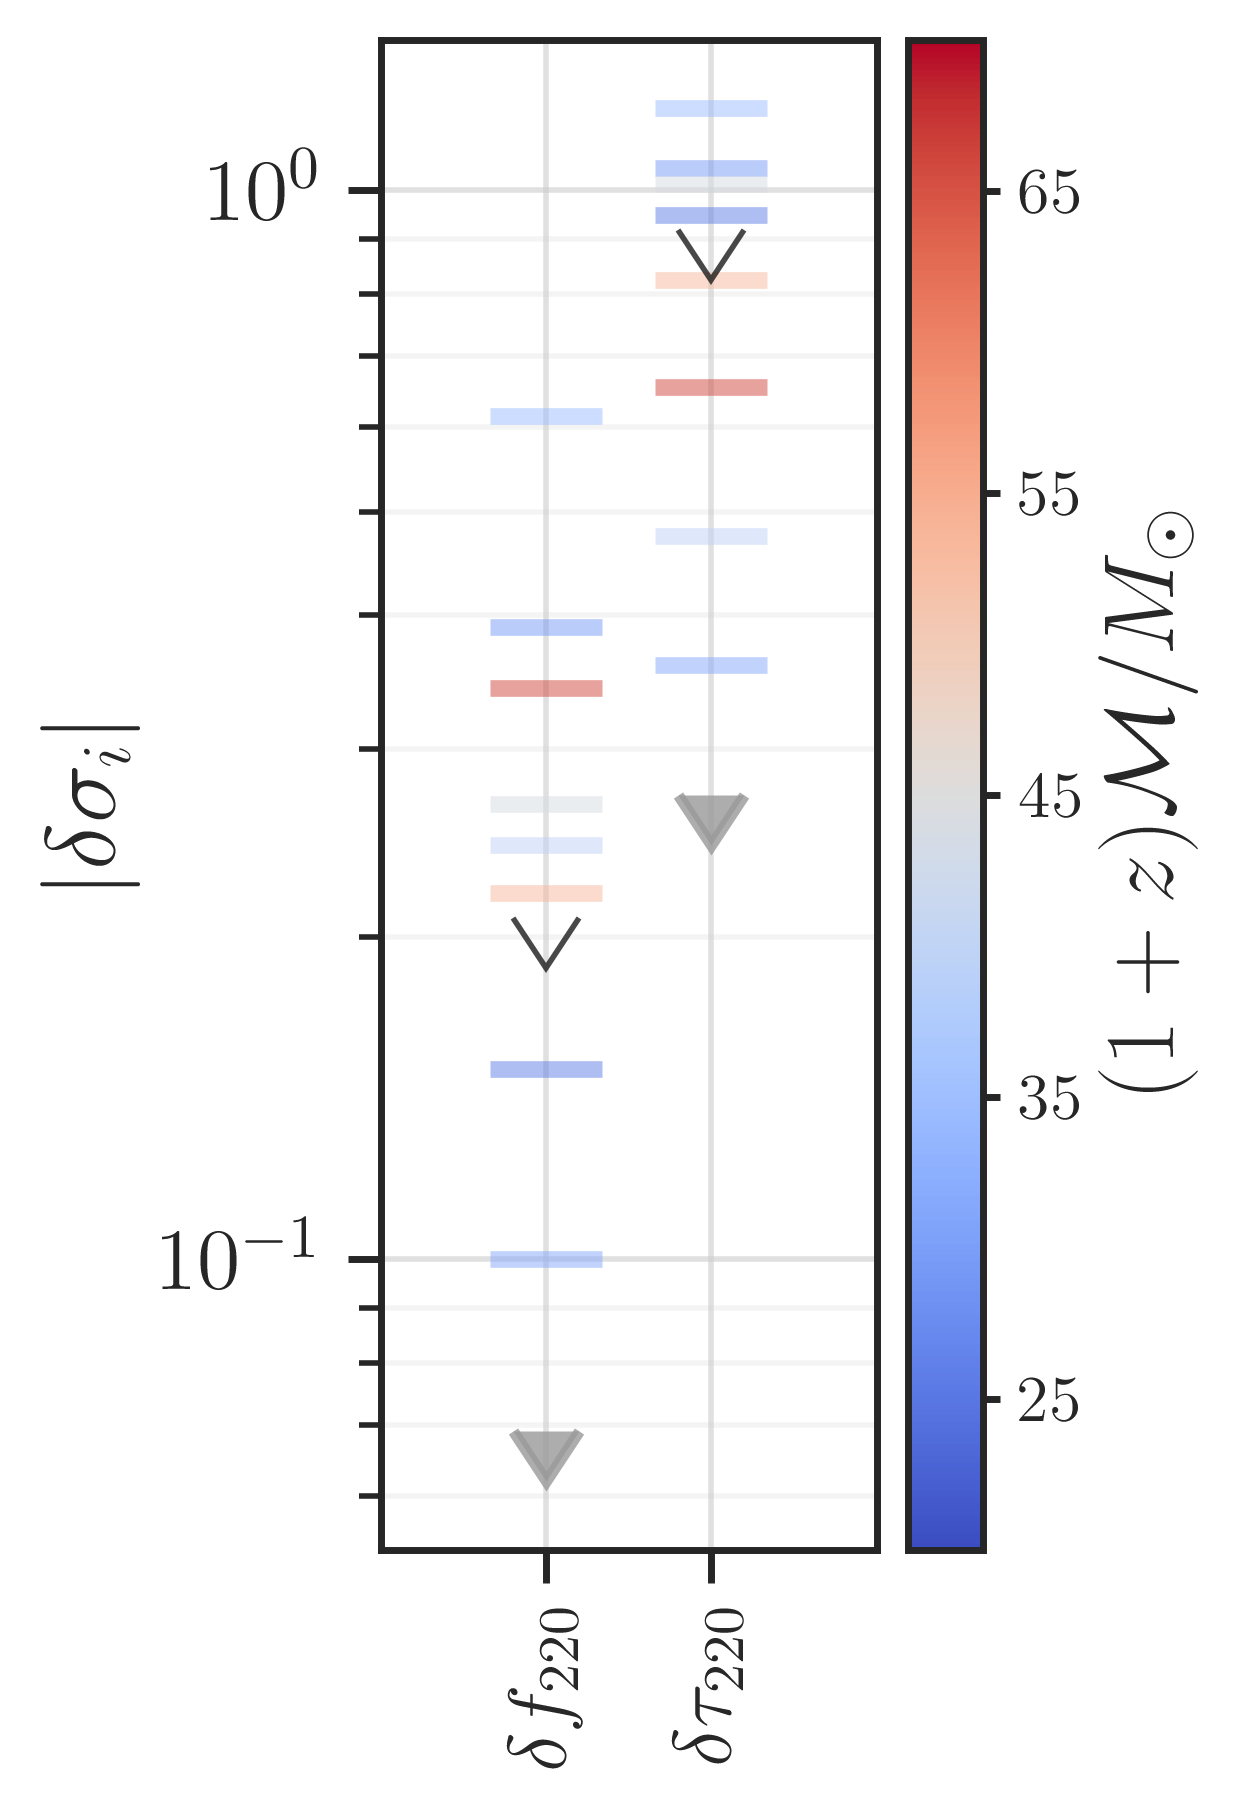

In [9]:
cmap      = plt.cm.coolwarm
# norm      = matplotlib.colors.Normalize(vmin=(5.0), vmax=(45.0));
norm      = matplotlib.colors.DivergingNorm(45, vmin=(20.0), vmax=(70.0));

print(f"Event \t Chirp Mass \t CI:domega220 \t CI:domega220")

fig = plt.figure(figsize=(2,5), dpi=200)
ax = fig.add_subplot(111)

for event in event_list:
    e = utils.Event(event)
    
    domega220_pts, domega220_pdf = kde_helper(sample_dict["domega_220"][event], xlow=prior_dict["domega_220-min"][event], xhigh=prior_dict["domega_220-max"][event])
    dtau220_pts, dtau220_pdf = kde_helper(sample_dict["dtau_220"][event], xlow=prior_dict["dtau_220-min"][event], xhigh=prior_dict["dtau_220-max"][event])
    
    domega220_left, domega220_right = utils.get_sym_interval_from_pdf(domega220_pdf, domega220_pts, p=0.9, normalize=True)
    dtau220_left, dtau220_right = utils.get_sym_interval_from_pdf(dtau220_pdf, dtau220_pts, p=0.9, normalize=True)

    
    c = cmap(norm(get_mc(event)))
    
    print(f"{event} \t {get_mc(event)} \t {domega220_right - domega220_left:.2f} \t {dtau220_right - dtau220_left:.2f}")
    
    ax.semilogy(0, domega220_right - domega220_left, c=c, **kwargs['event'])
    ax.semilogy(1, dtau220_right - dtau220_left, c=c, **kwargs['event'])


# condifence intervals on combined posteriors    
domega220_comb_left, domega220_comb_right = utils.get_sym_interval_from_pdf(df_220_comb_pdf, df_220_comb_pts, p=0.9, normalize=True)
dtau220_comb_left, dtau220_comb_right = utils.get_sym_interval_from_pdf(dtau_220_comb_pdf, dtau_220_comb_pts, p=0.9, normalize=True)
ax.semilogy(0, domega220_comb_right - domega220_comb_left, **kwargs['GWTC-2 (Phenom)'], label="joint\nlikelihood")
ax.semilogy(1, dtau220_comb_right - dtau220_comb_left, **kwargs['GWTC-2 (Phenom)'])

print(f"Joint lklhd \t -- \t {domega220_comb_right - domega220_comb_left:.2f} \t {dtau220_comb_right - dtau220_comb_left:.2f}")

# condifence intervals on hierarchical posteriors
domega220_hier_left, domega220_hier_right = utils.get_sym_interval_from_pdf(df_220_hier_pdf, df_220_hier_pts, p=0.9, normalize=True)
dtau220_hier_left, dtau220_hier_right = utils.get_sym_interval_from_pdf(dtau_220_hier_pdf, dtau_220_hier_pts, p=0.9, normalize=True)
ax.semilogy(0, domega220_hier_right - domega220_hier_left, **kwargs['GWTC-2 (SEOB)'], label="hierarchically\ncombined" )
ax.semilogy(1, dtau220_hier_right - dtau220_hier_left, **kwargs['GWTC-2 (SEOB)'])
    
print(f"Hier \t -- \t {domega220_hier_right - domega220_hier_left:.2f} \t {dtau220_hier_right - dtau220_hier_left:.2f}")    
    
ax.set_xticks(np.arange(len(params)))
ax.set_xticklabels([r"$\delta f_{220}$",r"$\delta \tau_{220}$"], fontsize=15, rotation=90)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("$|\delta \sigma_i|$")
# grid 
ax.grid(which='major',axis='both', b=True, linestyle='-',alpha=0.6)
ax.grid(which='minor',b=True, linestyle='-',alpha=0.2)    

# Set x- and y-limits    
ax.set_xlim(-1.0, 2.0)

# add colorbar
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(5, 65, 7))
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=12)
cbar.ax.tick_params('y', length=3, which='major')
cbar.set_label(r'$%s$' % utils.Parameter('mc').latex, fontsize=18, labelpad=2.5)

plt.savefig("../../papers/intro_paper/figures/rin_all_events_bounds.pdf", bbox_inches="tight")
plt.savefig("../../papers/intro_paper/figures/rin_all_events_bounds.png", bbox_inches="tight")

## Table with reconstructed values

In [10]:
data_loc_full_pe_dict = {"S190519bj":"../../data/rin/S190519bj/rin_S190519bj_pseobnrv4hm.h5", 
              "S190521r":"../../data/rin/S190521r/rin_S190521r_pseobnrv4hm.h5",
              "S190630ag":"../../runs/O3a/S190630ag/220/cbcBayes/posterior_samples.dat",
              "S190828j":"../../runs/O3a/S190828j/220/cbcBayes/posterior_samples.dat",
              "S190910s":"../../data/rin/S190910s/rin_S190910s_pseobnrv4hm.h5",
              "GW150914":"../../runs/O1O2/GW150914/220/cbcBayes/posterior_samples.dat",
              "GW170104":"../../runs/O1O2/GW170104/220/cbcBayes/posterior_samples.dat",
              "GW170729":"../../runs/O1O2/GW170729/220/cbcBayes/posterior_samples.dat"}

In [11]:
# using fitting formulas from https://arxiv.org/pdf/gr-qc/0512160.pdf
# to get final mass and final spin from omega220 and tau220.
# See eqs.2.1, E1 and E2, and table VIII for fitting coefficients

def Mjfinal220(omega220,tau220):

    jf=1-pow((omega220*tau220/2.-0.7)/(1.4187),-1/0.4990)
    Mf=((1.5251 - 1.1568*pow((1 - jf),0.1292))/omega220)*(pow(lal.C_SI,3)/lal.G_SI/lal.MSUN_SI)
    
    idx, = np.where(jf < 0.)
    jf[idx] = 0.
    
    Mf[np.isnan(Mf)] = 0.
    jf[np.isnan(jf)] = 0.

    return Mf,jf

params = ["freq_modGR", "tau_modGR", "Mf", "af"]
sample_dict = {}

for param in params:
    sample_dict[param] = {}

for idx, event in enumerate(event_list):
    
    if data_loc_full_pe_dict[event].endswith('.h5'):
        
        pos_file = h5py.File(data_loc_full_pe_dict[event], "r")
        samples = pos_file["pSEOBNRv4HM"]["posterior_samples"]

        m1, m2, a1z, a2z, domega, dtau = samples["mass_1"], samples["mass_2"],\
                                         samples["spin_1z"], samples["spin_2z"],\
                                         samples["domega220"], samples["dtau220"]

    else:
        samples = np.genfromtxt(data_loc_full_pe_dict[event], dtype=None, names=True)
        m1, m2, a1z, a2z, domega, dtau = samples["m1"], samples["m2"],\
                                         samples["a1z"], samples["a2z"],\
                                         samples["domega220"], samples["dtau220"]
    
    omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, [2,2])
    freq_GR = omega_GR/(2.*np.pi)
        
    omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
    freq_modGR = omega_modGR/(2.*np.pi)    
    Mf, af = Mjfinal220(2.*np.pi*freq_modGR,tau_modGR)
    
    tau_modGR *= 1.e3
    
    sample_dict["freq_modGR"][event] = freq_modGR
    sample_dict["tau_modGR"][event] = tau_modGR
    sample_dict["Mf"][event] = Mf
    sample_dict["af"][event] = af

/Users/abhirupghosh/envs/pSEOBNRv4HM_tgr_injection/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


In [12]:
# Prepare the dictionary that should be fed to jinja2
jinja2_data_dict = []
for idx, event in enumerate(event_list):
    e = utils.Event(event)
    jinja2_data_dict.append({"catalog_id": e.name})

In [13]:
# Compute summary statistics: median, 90% CI limits
for idx, event in enumerate(event_list):
    for param in params:
        try:
            jinja2_data_dict[idx][param+"_median"] = np.median(sample_dict[param][event])
            # 5th-percentile relative to the median
            jinja2_data_dict[idx][param+"_lower_limit"] = np.median(sample_dict[param][event]) - np.percentile(sample_dict[param][event], 5)
            # 95th-percentile relative to the median
            jinja2_data_dict[idx][param+"_upper_limit"] = np.percentile(sample_dict[param][event], 95) - np.median(sample_dict[param][event])
        except:
            # That parameter does not exist in the dict, returning np.nan
            jinja2_data_dict[idx][param+"_median"] = None
            # 5th-percentile relative to the median
            jinja2_data_dict[idx][param+"_lower_limit"] = None
            # 95th-percentile relative to the median
            jinja2_data_dict[idx][param+"_upper_limit"] = None       

In [14]:
# Format the output, and show a dash for nan
for idx, event in enumerate(event_list):
    # IMR
    try:
        jinja2_data_dict[idx]["freq_modGR"] = "${0:.0f}^{{+{1:.0f}}}_{{-{2:.0f}}}$".format(jinja2_data_dict[idx]["freq_modGR_median"], jinja2_data_dict[idx]["freq_modGR_upper_limit"], jinja2_data_dict[idx]["freq_modGR_lower_limit"])
        jinja2_data_dict[idx]["tau_modGR"] = "${0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$".format(jinja2_data_dict[idx]["tau_modGR_median"], jinja2_data_dict[idx]["tau_modGR_upper_limit"], jinja2_data_dict[idx]["tau_modGR_lower_limit"])
        jinja2_data_dict[idx]["Mf"] = "${0:.0f}^{{+{1:.0f}}}_{{-{2:.0f}}}$".format(jinja2_data_dict[idx]["Mf_median"], jinja2_data_dict[idx]["Mf_upper_limit"], jinja2_data_dict[idx]["Mf_lower_limit"])
        jinja2_data_dict[idx]["af"] = "${0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$".format(jinja2_data_dict[idx]["af_median"], jinja2_data_dict[idx]["af_upper_limit"], jinja2_data_dict[idx]["af_lower_limit"])
    except:
        jinja2_data_dict[idx]["freq_modGR"] = "$-$"
        jinja2_data_dict[idx]["tau_modGR"] = "$-$"
        jinja2_data_dict[idx]["Mf"] = "$-$"
        jinja2_data_dict[idx]["af"] = "$-$"
        
    print(f"{event} \t {jinja2_data_dict[idx]['freq_modGR']} \t {jinja2_data_dict[idx]['tau_modGR']} \t {jinja2_data_dict[idx]['Mf']} \t {jinja2_data_dict[idx]['af']}")

GW150914 	 $258^{+17}_{-13}$ 	 $4.5^{+1.1}_{-0.9}$ 	 $71^{+9}_{-10}$ 	 $0.8^{+0.1}_{-0.2}$
GW170104 	 $291^{+15}_{-30}$ 	 $5.5^{+3.5}_{-2.4}$ 	 $74^{+11}_{-20}$ 	 $0.9^{+0.1}_{-0.4}$
GW170729 	 $152^{+13}_{-9}$ 	 $10.7^{+4.2}_{-3.7}$ 	 $141^{+20}_{-29}$ 	 $0.9^{+0.1}_{-0.2}$
S190519bj 	 $124^{+12}_{-13}$ 	 $10.3^{+3.6}_{-3.1}$ 	 $155^{+24}_{-30}$ 	 $0.8^{+0.1}_{-0.3}$
S190521r 	 $205^{+15}_{-12}$ 	 $5.3^{+1.5}_{-1.2}$ 	 $86^{+12}_{-14}$ 	 $0.7^{+0.1}_{-0.3}$
S190630ag 	 $248^{+32}_{-53}$ 	 $3.9^{+2.4}_{-1.8}$ 	 $66^{+19}_{-42}$ 	 $0.6^{+0.3}_{-0.6}$
S190828j 	 $258^{+201}_{-28}$ 	 $4.2^{+4.2}_{-1.9}$ 	 $67^{+26}_{-30}$ 	 $0.8^{+0.2}_{-0.7}$
S190910s 	 $174^{+12}_{-8}$ 	 $9.5^{+3.1}_{-2.7}$ 	 $123^{+15}_{-18}$ 	 $0.9^{+0.0}_{-0.1}$


In [15]:
# Jinja2 template for the table in LaTeX
LaTex_table_jinja_template = r"""
\begin{tabular}{lllll}
\toprule
Event & $\fngr{220}$ (Hz) & $\taungr{220}$ (ms) & $M_f/\Mo$ & $a_f$ \\[0.075cm]
\midrule
\hline
{% for event in  jinja2_data_dict %}
{{ event.catalog_id }} &
{{ event.freq_modGR }} &
{{ event.tau_modGR }} &
{{ event.Mf }} &
{{ event.af }}
\\[0.075cm]
{% endfor %}
\bottomrule
\end{tabular}
"""

In [16]:
Template(LaTex_table_jinja_template).stream(jinja2_data_dict=jinja2_data_dict).dump("../../papers/intro_paper/table_lvc_results.tex") 